# Anomaly Detection with TCLab Sensor Data
Exploring concepts of anomaly detection with supervised machine learning classifiers, using real data generated from the Temperature Control Lab

## Problem Overview

We can imagine the problem as this: we have a heater for our garage workshop, with a simple on/off setting. We can program the heater to turn on or off for certain amounts of time each day to keep the temperature at a comfortable level. There are, of course, more sophisticated control systems we could use; however, this is designed as an introduction to anomaly detection with machine learning, so we’ll keep the raw data simple for now.

Under normal circumstances, it’s a simple enough exercise to verify that the heater is on and doing its job — just look at the temperature and see if it’s going up. But what if there are external factors that complicate the evaluation? Maybe the garage door was left open and lets a draft in, or perhaps some of your equipment starts overheating. Or worse yet, what if there’s a cyberattack on the temperature control, and it’s masked by the attackers? Is there a way to look at the data we’re gathering and determine when something is going wrong? This is the heart of anomaly detection.


With a supervised classifier, we can look at the sensor data and train it to classify when the heater is on or off. Since we also know when the heater should be on or off, we can then apply the classifier to any new data coming in and determine whether the behavior lines up with the data we see. If the two don’t match, we know there’s an anomaly of some type, and can investigate further.

In [1]:
# Processing and plotting packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Classifier packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

Data is generated with the TCLab; files to generate data can be found at https://github.com/nrlewis929/TCLab_anomaly_detection_basic; the TCLab can be purchased at https://www.amazon.com/TCLab-Temperature-Control-Lab/dp/B07GMFWMRY/

In [2]:
# Import training data
df = pd.read_csv('train.csv')

In [3]:
df.head()

,t,T1,Q1
0,0.000000,33.14,0.0
1,1.000219,33.27,0.0
2,2.000726,33.47,0.0
3,3.001613,33.72,0.0
4,4.001626,33.79,0.0


In [4]:
# Find rolling average temperature to smooth out sensor noise
df['T1_ave'] = df['T1'].rolling(10).mean()

# Split into train and validation datasets
train, val = train_test_split(df, test_size=0.2, shuffle=False)
train = train.copy(deep=True)
val = val.copy(deep=True)

In [5]:
df.head()

,t,T1,Q1,T1_ave
0,0.000000,33.14,0.0,NaN
1,1.000219,33.27,0.0,NaN
2,2.000726,33.47,0.0,NaN
3,3.001613,33.72,0.0,NaN
4,4.001626,33.79,0.0,NaN


<AxesSubplot:>

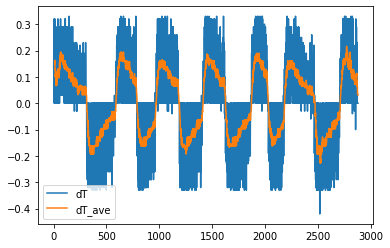

In [6]:
# Demonstrate difference of rolling average smoothing
train['dT'] = train['T1'].diff()
train['dT_ave'] = train['T1_ave'].diff()
train[['dT','dT_ave']].plot()

## Train - Initial
Use the raw training data to train a classifier. This demonstrates the need for feature engineering.

In [7]:
# Split into input and output data
Xtrain = train[['T1']].values
ytrain = train[['Q1']].values

# Formatting shape of y data to remove warning
ytrain = np.ravel(ytrain)

# Scale
s = MinMaxScaler()
Xtrain_s = s.fit_transform(Xtrain)

# Load classifier model; default hyperparameters
lr = LogisticRegression()

# Fit classifier on training data and predict
lr.fit(Xtrain_s,ytrain)
yp = lr.predict(Xtrain_s)
train['LR_predict'] = yp

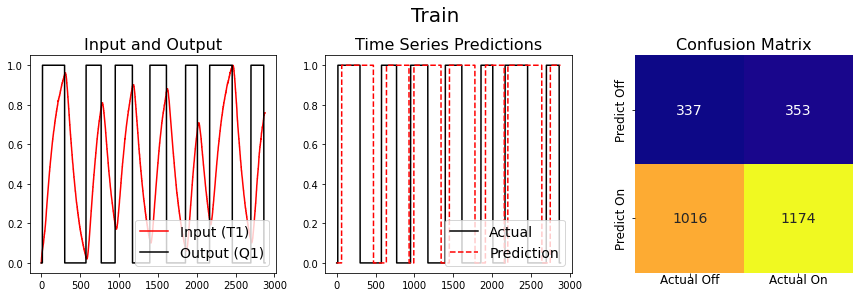

In [8]:
# Plot results as input/output, time series, and  confusion matrix
plt.figure(figsize=(15,4))
plt.suptitle('Train',size=20,y=1.05)

# 1) Inputs and outputs
plt.subplot(131)
plt.title('Input and Output',size=16)
plt.plot(Xtrain_s,'r-',label='Input (T1)')
plt.plot(ytrain,'k-',label='Output (Q1)')
plt.legend(loc='lower right',fontsize=14);

# 1) Time series plot
plt.subplot(132)
plt.title('Time Series Predictions',size=16)
plt.plot(train['Q1'],'k-',label='Actual')
plt.plot(train['LR_predict'],'r--',label='Prediction')
plt.legend(loc='lower right',fontsize=14)

# 2) Confusion matrix plot (false positive, false negative, true positive, true negative)
confusion = metrics.confusion_matrix(yp,ytrain) 
plt.subplot(133)
plt.title('Confusion Matrix',size=16)
ax = sns.heatmap(confusion, annot=True, cmap='plasma',square=True,cbar=False,fmt='g',annot_kws={"size": 14})
ax.set_xticklabels(['Actual Off','Actual On'],va='center',size=12)
ax.set_yticklabels(['Predict Off','Predict On'],va='center',size=12);

## Train - Final
Use the training data to:
1. Create a new feature for the classifier (change in Temperature)
2. Scale the input data (output data is already 0 or 1)
3. Train Logistic Regression classifier
4. Plot predictions for basic check

In [14]:
# Add change in Temperature as a new feature
train['dT'] = train['T1_ave'].diff()

# Drop empty columns and reset index
train.dropna(inplace=True)
train.reset_index(drop=True,inplace=True)

# Split into input and output data
Xtrain = train[['dT']].values
ytrain = train[['Q1']].values

In [15]:
train.head()

,t,T1,Q1,T1_ave,dT,dT_ave,LR_predict
0,11.005682,34.76,0.0,34.221,0.149,0.149,0.0
1,12.005686,35.08,0.0,34.382,0.161,0.161,0.0
2,13.006067,35.08,0.0,34.518,0.136,0.136,0.0
3,14.006479,35.08,0.0,34.647,0.129,0.129,0.0
4,15.007374,35.37,1.0,34.773,0.126,0.126,0.0


In [16]:
# Formatting shape of y data to remove warning
ytrain = np.ravel(ytrain)

# Scale
s = MinMaxScaler()
Xtrain_s = s.fit_transform(Xtrain)

# Load classifier model; default hyperparameters
lr = LogisticRegression()

# Fit classifier on training data and predict
lr.fit(Xtrain_s,ytrain)
yp = lr.predict(Xtrain_s)
train['LR_predict'] = yp

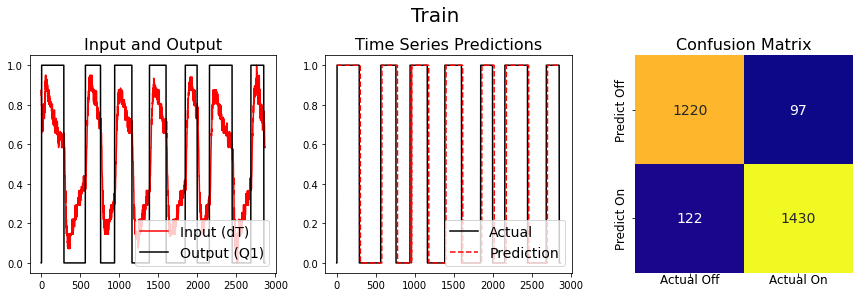

In [17]:
# Plot results as input/output, time series, and  confusion matrix
plt.figure(figsize=(15,4))
plt.suptitle('Train',size=20,y=1.05)

# 1) Inputs and outputs
plt.subplot(131)
plt.title('Input and Output',size=16)
plt.plot(Xtrain_s,'r-',label='Input (dT)')
plt.plot(ytrain,'k-',label='Output (Q1)')
plt.legend(loc='lower right',fontsize=14);

# 1) Time series plot
plt.subplot(132)
plt.title('Time Series Predictions',size=16)
plt.plot(train['Q1'],'k-',label='Actual')
plt.plot(train['LR_predict'],'r--',label='Prediction')
plt.legend(loc='lower right',fontsize=14)

# 2) Confusion matrix plot (false positive, false negative, true positive, true negative)
confusion = metrics.confusion_matrix(yp,ytrain) 
plt.subplot(133)
plt.title('Confusion Matrix',size=16)
ax = sns.heatmap(confusion, annot=True, cmap='plasma',square=True,cbar=False,fmt='g',annot_kws={"size": 14})
ax.set_xticklabels(['Actual Off','Actual On'],va='center',size=12)
ax.set_yticklabels(['Predict Off','Predict On'],va='center',size=12);

## Validation
Test the classifier performance on new data, carrying out the same preprocessing steps:
1. Create a new feature for the classifier (change in Temperature)
2. Scale the input data (output data is already 0 or 1)
3. Predict using Logistic Regression classifier
4. Plot predictions to check performance

In [18]:
# Add change in Temperature as a new feature
val['dT'] = val['T1_ave'].diff()
val.dropna(inplace=True)
val.reset_index(drop=True,inplace=True)

# Input and output data for LR 
Xval = val[['dT']].values
yval = val[['Q1']].values

# Formatting shape of y data to remove warning
yval = np.ravel(yval)

# Scale and save to dataframe
Xval_s = s.transform(Xval)

# Predict with classifier and save to dataframe
yp = lr.predict(Xval_s)
val['LR_predict'] = yp


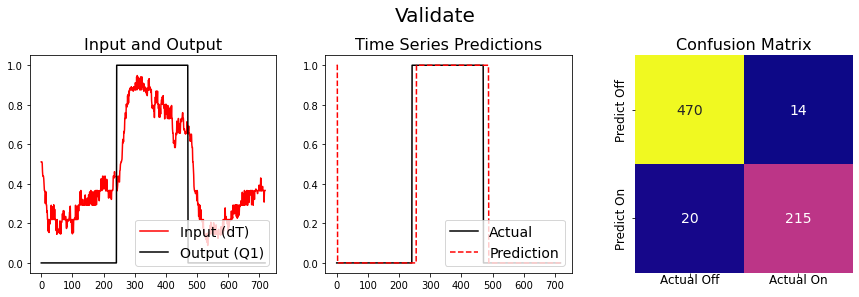

In [19]:
# Plot results as input/output, time series, and  confusion matrix
plt.figure(figsize=(15,4))
plt.suptitle('Validate',size=20,y=1.05)

# 1) Inputs and outputs
plt.subplot(131)
plt.title('Input and Output',size=16)
plt.plot(Xval_s,'r-',label='Input (dT)')
plt.plot(yval,'k-',label='Output (Q1)')
plt.legend(loc='lower right',fontsize=14);

# 1) Time series plot
plt.subplot(132)
plt.title('Time Series Predictions',size=16)
plt.plot(val['Q1'],'k-',label='Actual')
plt.plot(val['LR_predict'],'r--',label='Prediction')
plt.legend(loc='lower right',fontsize=14)

# 2) Confusion matrix plot (false positive, false negative, true positive, true negative)
confusion = metrics.confusion_matrix(yp,yval) 
plt.subplot(133)
plt.title('Confusion Matrix',size=16)
ax = sns.heatmap(confusion, annot=True, cmap='plasma',square=True,cbar=False,fmt='g',annot_kws={"size": 14})
ax.set_xticklabels(['Actual Off','Actual On'],va='center',size=12)
ax.set_yticklabels(['Predict Off','Predict On'],va='center',size=12);

## Anomaly
Now use the classifier on a new set of data with some anamalous behavior (fan blowing across the heater).
1. Create a new feature for the classifier (change in Temperature)
2. Scale the input data (output data is already 0 or 1)
3. Predict using Logistic Regression classifier
4. Plot predictions and note any anomalies

Anomaly Detection with the Trained Classifier
Here is where the rubber hits the road. We know the classifier works well to tell us when the heater is on or off. Can it tell us when something unexpected is happening?
The process is really the same. The only difference is now we have an anomaly in the data. We’ll create the new feature (change in temperature, using the smoothed rolling average), scale the data, and feed it into the classifier to predict.

In [21]:
# Import anomalous data
anom = pd.read_csv('test.csv')

# Use average temperature to smooth out sensor noise
anom['T1_ave'] = anom['T1'].rolling(10).mean()

# Add change in Temperature as a new feature
anom['dT'] = anom['T1_ave'].diff()
anom.dropna(inplace=True)
anom.reset_index(drop=True,inplace=True)

# Retrieve values when the fan goes on and off
fan = anom['fan'].diff()[anom['fan'].diff() != 0].index.values
fan_on,fan_off = fan[1],fan[2]

# Classifier input and output values
Xanom = anom[['dT']].values
yanom = anom[['Q1']].values

# Formatting shape of y data to remove warning
yanom = np.ravel(yanom)

# Scale
Xanom_s = s.transform(Xanom)

# Predict with classifier
yp = lr.predict(Xanom_s)
anom['LR_predict'] = yp


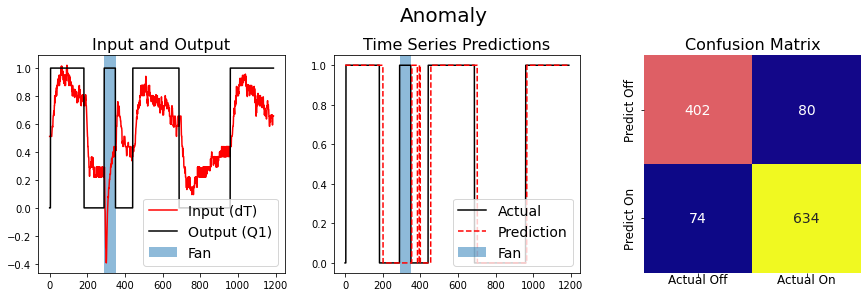

In [22]:
# Plot results as input/output, time series, and  confusion matrix
plt.figure(figsize=(15,4))
plt.suptitle('Anomaly',size=20,y=1.05)

# 1) Inputs and outputs
plt.subplot(131)
plt.title('Input and Output',size=16)
plt.plot(Xanom_s,'r-',label='Input (dT)')
plt.plot(yanom,'k-',label='Output (Q1)')
plt.axvspan(fan_on,fan_off,alpha=0.5,label='Fan')
plt.legend(loc='lower right',fontsize=14);

# 1) Time series plot
plt.subplot(132)
plt.title('Time Series Predictions',size=16)
plt.plot(anom['Q1'],'k-',label='Actual')
plt.plot(anom['LR_predict'],'r--',label='Prediction')
plt.axvspan(fan_on,fan_off,alpha=0.5,label='Fan')
plt.legend(loc='lower right',fontsize=14)

# 2) Confusion matrix plot (false positive, false negative, true positive, true negative)
confusion = metrics.confusion_matrix(yp,yanom) 
plt.subplot(133)
plt.title('Confusion Matrix',size=16)
ax = sns.heatmap(confusion, annot=True, cmap='plasma',square=True,cbar=False,fmt='g',annot_kws={"size": 14})
ax.set_xticklabels(['Actual Off','Actual On'],va='center',size=12)
ax.set_yticklabels(['Predict Off','Predict On'],va='center',size=12);